# imports

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import sys
import numpy as np
import pandas as pd
import torchvision
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from PIL import Image, ImageFile
from torch.utils.data import Dataset
from torch import optim, cuda
import torch
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0")
ImageFile.LOAD_TRUNCATED_IMAGES = True
from timeit import default_timer as timer
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import cv2
import random
from os.path import isfile

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(2019)

# Parameters

In [3]:
learning_rate=1e-4
epochs=15
num_workers=2
batch_size=16
IMG_SIZE    = 256

# Preprocess Image

In [4]:
train2015df = pd.read_csv('../input/retinopathy-train-2015/rescaled_train_896/trainLabels.csv')
train2015df["id_code"]=train2015df["image"]
train2015df["diagnosis"]=train2015df["level"]
train2015df=train2015df.drop(columns=["image","level"])
traindf = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
traindf2 = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
_,cvdf=train_test_split(traindf2, test_size=0.25, random_state=2019, stratify=traindf2.diagnosis)
testdf = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
traindf=traindf.append(train2015df)

In [5]:
train      = '../input/aptos2019-blindness-detection/train_images/'
test       = '../input/aptos2019-blindness-detection/test_images/'
train_2015 = '../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/'
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    if isfile(train_2015 + p + '.png'):
        return train_2015 + (p + ".png")
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p

def p_show(imgs, label_name=None, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(p, ax) in enumerate(zip(imgs, axes.flatten())): 
        img = Image.open(expand_path(p))
        ax.imshow(img)
        ax.set_title(train_df[train_df.id_code == p].diagnosis.values)

In [6]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(image, sigmaX=10 ):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

# dataset and Data Loader

In [7]:
class RetinopathyDatasetTest(Dataset):
    def __init__(self, data, transform, dtype='train',mode='train'):
        self.data = data
        self.transform = transform
        self.dtype=dtype
        self.mode=mode
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory='../input/aptos2019-blindness-detection/'+self.dtype+'_images'
        #img_name = os.path.join(directory, self.data.loc[idx, 'id_code'] + '.png')
        img_name=expand_path(self.data.loc[idx, 'id_code'])
        #print(img_name)
        image = cv2.imread(img_name)
        image = load_ben_color(image, sigmaX=10 )
        image = Image.fromarray(image)
        image = self.transform(image)
        label=self.data['diagnosis'][idx]
        if(self.mode=='test'):
            return {'image': image}
        elif(self.mode=='train'):
            return image,label
        else :
            return {'image': image},label

In [8]:
train_df, val_df = train_test_split(traindf, test_size=0.25, random_state=2019, stratify=traindf.diagnosis)
train_df=train_df.reset_index(drop=True)
val_df=val_df.reset_index(drop=True)
cvdf=cvdf.reset_index(drop=True)
sample_df=pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.55387044 ,0.5336158 , 0.5232084 ], [0.2063595 , 0.18827829, 0.15147245])
])
train_dataset = RetinopathyDatasetTest(data=train_df,
                                      transform=transform,dtype='train',mode='train')
valid_dataset = RetinopathyDatasetTest(data=val_df,
                                      transform=transform,dtype='train',mode='train')
test_dataset = RetinopathyDatasetTest(sample_df,
                                      transform=transform,dtype='test',mode='test')
cv_dataset= RetinopathyDatasetTest(cvdf,
                                      transform=transform,dtype='train',mode='train')
#for confusion matrix validation
#valid_dataset = RetinopathyDatasetTest(csv_file='../input/train.csv',transform=transform,dtype='train',mode='valid')
#tr, val = train_test_split(train.diagnosis, stratify=train.diagnosis, test_size=0.25)
#train_sampler = SubsetRandomSampler(list(tr.index))
#valid_sampler = SubsetRandomSampler(list(val.index))
#valid_dataset = torch.utils.data.Subset(dataset, list(val.index))
#train_dataset=torch.utils.data.Subset(dataset, list(tr.index))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)
cv_loader=torch.utils.data.DataLoader(cv_dataset, batch_size=batch_size, num_workers=num_workers)

## Model

In [9]:
model = torch.load("../input/pytorch-resnext/complete_modelv40.pth")

# Fine Tune

In [10]:
def finetune(model,learningRate,n_epochs=epochs):
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learningRate,weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    save_file_name='resnetx101.pt'
    max_epochs_stop=5
    print_every=1
    for param in model.parameters():
                param.requires_grad = True
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    overall_start = timer()
    for epoch in (range(n_epochs)):
        torch.cuda.empty_cache()
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_mse = 0
        valid_mse = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate((train_loader)):
            data, target =data.cuda(), target.cuda().float()
            target=target.unsqueeze(1)
            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() 
            # Calculate accuracy by finding max log probability
            #_, pred = torch.max(output, dim=1)
            #correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            #accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            #train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1
            if(epoch%2)==0:
                # Don't need to keep track of gradients
                with torch.no_grad():
                    # Set to evaluation mode
                    model.eval()

                    # Validation loop
                    for data, target in valid_loader:
                        # Tensors to gpu
                        data, target = data.cuda(), target.cuda().float()
                        target=target.unsqueeze(1)
                        # Forward pass
                        output = model(data)

                        # Validation loss
                        loss = criterion(output, target)
                        # Multiply average loss times the number of examples in batch
                        valid_loss += loss.item()
                        # Calculate validation accuracy
                        #_, pred = torch.max(output, dim=1)
                        #correct_tensor = pred.eq(target.data.view_as(pred))
                        #accuracy = torch.mean(
                            #correct_tensor.type(torch.FloatTensor))
                        # Multiply average accuracy times the number of examples
                        #valid_acc += accuracy.item() * data.size(0)

                    # Calculate average losses
                    train_loss = train_loss / len(train_loader)
                    valid_loss = valid_loss / len(valid_loader)

                    # Calculate average accuracy
                    #train_acc = train_acc / len(train_loader.dataset)
                    #valid_acc = valid_acc / len(valid_loader.dataset)

                    history.append([train_loss, valid_loss,scheduler.get_lr()[0]])

                    # Print training and validation results
                    if (epoch + 1) % print_every == 0:
                        print(
                            f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                        )
                        print('lr:', scheduler.get_lr()[0])
                        #print(
                        #    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                        #)

                    # Save the model if validation loss decreases
                    if valid_loss < valid_loss_min:
                        # Save model
                        torch.save(model.state_dict(), save_file_name)
                        # Track improvement
                        epochs_no_improve = 0
                        valid_loss_min = valid_loss
                        best_epoch = epoch

                    # Otherwise increment count of epochs with no improvement
                    else:
                        epochs_no_improve += 1
                        # Trigger early stopping
                        if epochs_no_improve >= max_epochs_stop:
                            print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
                            total_time = timer() - overall_start
                            print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                            # Load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # Attach the optimizer
                            model.optimizer = optimizer

                            # Format history
                            history = pd.DataFrame(history,columns=['train_loss', 'valid_loss','Learning_rate'])
                            return model,history
        scheduler.step()
    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} ')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')
    # Format history
    history = pd.DataFrame(history,columns=['train_loss', 'valid_loss','Learning_rate'])
    return model,history

model,history=finetune(model,learningRate=1e-4,n_epochs=16)

# Plot Losses

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Losses')
plt.title('Training and Validation Losses')

history

## train optimized Cohen kappa

In [11]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']


In [12]:
def Run_validation():
    torch.cuda.empty_cache()
    valid_preds = []
    labels=[]
    tk0 = tqdm(cv_loader)
    for ii, (x_batch,label) in enumerate(tk0):
         with torch.no_grad():
            #x_batch = x_batch["image"]
            pred = model(x_batch.to(device))
            valid_preds.append(pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1))
            labels.append(label)
    predict_valid=valid_preds[0]
    for i in range(1,len(cv_loader)):
        predict_valid=np.append(predict_valid,valid_preds[i])
    label_valid=labels[0].numpy()
    for i in range(1,len(cv_loader)):
        label_valid=np.append(label_valid,labels[i].numpy())
    return predict_valid,label_valid

In [13]:
def confusionMatrics(preds_valid,label_valid):
    labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
    cnf_matrix = confusion_matrix(label_valid, preds_valid)
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(16, 7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()

In [14]:
predict_valid,label_valid=Run_validation()

In [15]:

optR = OptimizedRounder()
optR.fit(predict_valid,label_valid)
coefficients=optR.coefficients()
print(coefficients)
preds_valid=optR.predict(predict_valid,coefficients)

0.9358607123999432
[0.59997161 1.38376158 2.19513504 3.12641114]


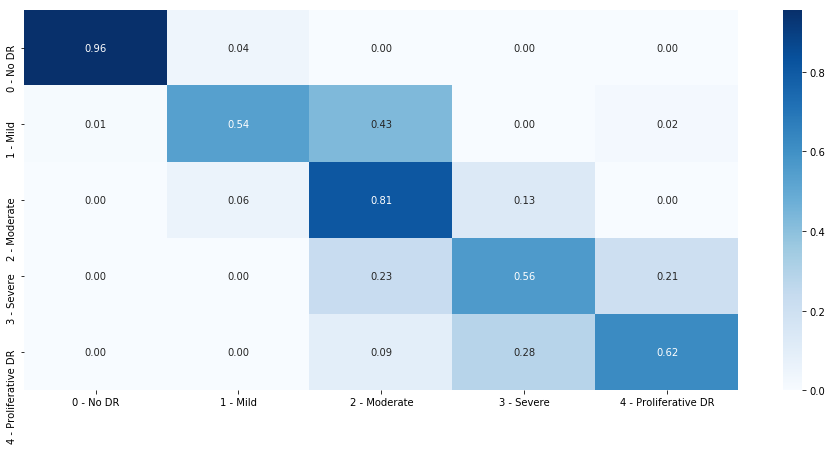

In [16]:
confusionMatrics(preds_valid,label_valid)

In [17]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(preds_valid, label_valid, weights='quadratic'))

Train Cohen Kappa score: 0.936


# Validation

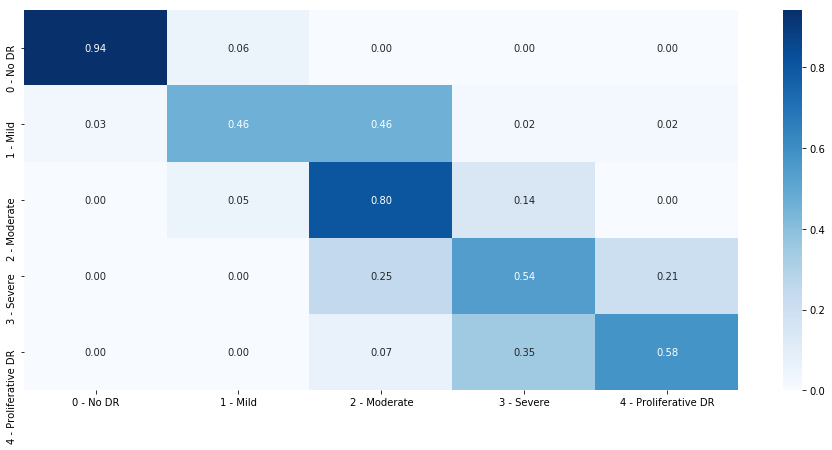

In [18]:
predict_valid_1,label_valid_1=Run_validation()
preds_valid_1=optR.predict(predict_valid_1,coefficients)
confusionMatrics(preds_valid_1,label_valid_1)

In [19]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(preds_valid_1, label_valid_1, weights='quadratic'))

Train Cohen Kappa score: 0.929


# Witout Optimizing

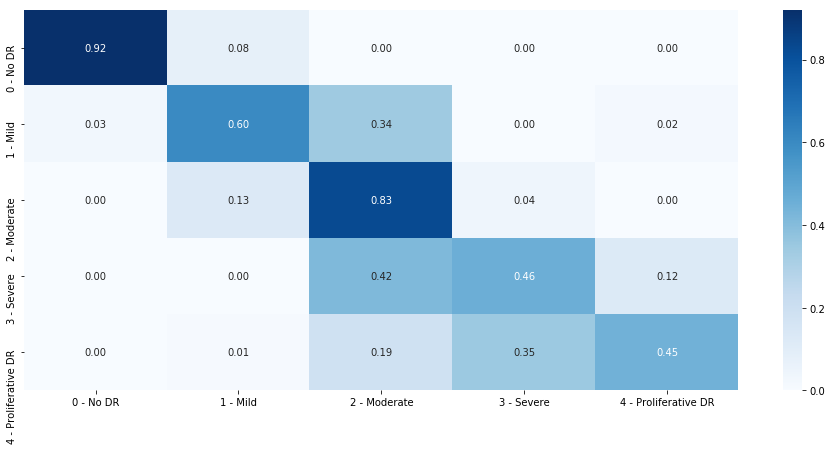

In [20]:
coefficients_1=[0.5, 1.5, 2.5, 3.5]
preds_valid_2=optR.predict(predict_valid_1,coefficients_1)
confusionMatrics(preds_valid_2,label_valid_1)

In [21]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(preds_valid_2, label_valid_1, weights='quadratic'))

Train Cohen Kappa score: 0.912


# Predict With TTA

In [22]:
for i in tqdm(range(10)):
    test_preds=[]
    torch.cuda.empty_cache()
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_preds1 = np.zeros((len(test_dataset), 1))
    tk0 = tqdm(test_data_loader)
    for i, x_batch in enumerate(tk0):
        with torch.no_grad():
            x_batch = x_batch["image"]
            pred = model(x_batch.to(device))
            test_preds1[i * batch_size:(i + 1) * batch_size] = pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)
            test_preds.append(test_preds1)
predict = np.mean(test_preds, axis=0)

In [23]:
test_preds=optR.predict(predict,coefficients)
sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
sample.diagnosis = test_preds.astype(int)
sample.to_csv("submission.csv", index=False)

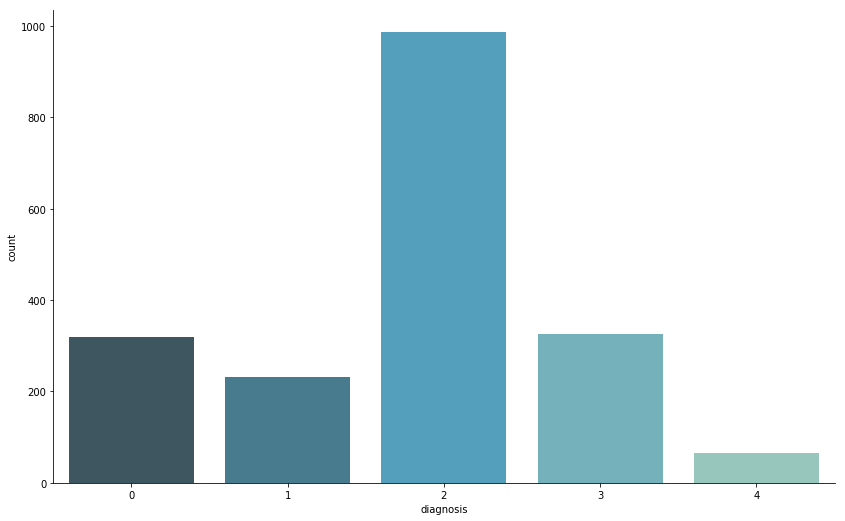

In [24]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=sample, palette="GnBu_d")
sns.despine()
plt.show()

In [25]:
sample.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [26]:
torch.save(model,"final_traindv16.pth")